In [1]:
import argparse
import torch
import numpy as np
import pandas as pd
from PIL import Image
import glob, os, re
from torch.utils.data.dataset import Dataset
from torchvision import transforms
import random
from tqdm import tqdm
import torch.nn.functional as F
from sklearn.model_selection import StratifiedKFold
import matplotlib.pyplot as plt
import cv2

import  torchvision.models as models
import torch.nn as nn
from torch.utils.data import DataLoader
from torch.autograd import Variable
from sklearn.metrics import roc_auc_score, confusion_matrix, roc_curve
from efficientnet_pytorch import EfficientNet

import import_ipynb
# from models_3ch import MyEffientnet_b1
from clinical_data_loader import ImageDataset 
from clinical_data_loader_external_test import ImageDataset as t_ImageDataset
from clinical_data_loader_external_validation import ImageDataset as v_ImageDataset

importing Jupyter notebook from clinical_data_loader.ipynb
importing Jupyter notebook from clinical_data_loader_external_test.ipynb
importing Jupyter notebook from clinical_data_loader_external_validation.ipynb


In [2]:
import warnings
warnings.filterwarnings("ignore", category=np.VisibleDeprecationWarning) 

In [3]:
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"

In [4]:
os.environ["CUDA_VISIBLE_DEVICES"]="1"

In [5]:
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

random_seed = 123 #123

torch.manual_seed(random_seed)
np.random.seed(random_seed)
random.seed(random_seed)

In [6]:
num_epoch = 10
batch_size = 32


train_transforms = {
    'train_aug' : transforms.Compose([
        transforms.Resize(256),
        transforms.RandomHorizontalFlip(0.5), #0.5
        transforms.RandomVerticalFlip(0.5), #0.5
        transforms.CenterCrop(240),
        transforms.ToTensor(),
    ]),
}

test_transforms={
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(240),
        transforms.ToTensor(),
    ]),
}


In [7]:
img_root = '/home/SMC_data_2101xx_EGFR_deeplearning/EGFR_deep_learning/3ch_img_minmax/img'
label_pth = '/home/SMC_data_2101xx_EGFR_deeplearning/EGFR_deep_learning/3ch_img_minmax/patient_information_clinical.xlsx'

In [8]:
save_root = '/home/SMC_data_2101xx_EGFR_deeplearning/EGFR_deep_learning/3ch_img_minmax/result/final_re'

In [9]:
class MyEffientnet_b1_clinical(nn.Module):
    def __init__(self,out_features1, out_features2, out_features3, out_features4, out_features5, out_features6, 
                 out_features7, out_features8, model_name='efficientnet-b1',class_num=45,initfc_type='normal',gain=0.2):
        super(MyEffientnet_b1_clinical, self).__init__()
        
        
        self.clinical_fc1 = nn.Linear(3, out_features5) #(3, 32)
        self.clinical_fc2 = nn.Linear(out_features5, out_features6) #(32, 256)
        self.clinical_fc3 = nn.Linear(out_features6, out_features7) #(256, 1024)
        self.clinical_fc4 = nn.Linear(out_features7, out_features8) #(1024, 1280)

        
        
        model = EfficientNet.from_pretrained(model_name)
        self.model = model
        self.fc1 = nn.Linear(1280 + out_features8, out_features1) #1280
        self.fc2 = nn.Linear(out_features1, out_features2)
        self.fc3 = nn.Linear(out_features2, out_features3)
        self.fc4 = nn.Linear(out_features3, out_features4)
        self.fc5 = nn.Linear(out_features4, 2)
        self.dropout = nn.Dropout(0.5)
        
        self.batchnorm = nn.BatchNorm1d(1280 + out_features8)
        self.batchnorm1 = nn.BatchNorm1d(out_features1)
        self.batchnorm2 = nn.BatchNorm1d(out_features2)
        self.batchnorm3 = nn.BatchNorm1d(out_features3)
        self.batchnorm4 = nn.BatchNorm1d(out_features4)
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()
        
        

        
        
        if hasattr(self.fc1, 'bias') and self.fc1.bias is not None:
            nn.init.constant_(self.fc1.bias.data, 0.0)
        if initfc_type == 'normal':
            nn.init.normal_(self.fc1.weight.data, 0.0, gain)
        elif initfc_type == 'xavier':
            nn.init.xavier_normal_(self.fc1.weight.data, gain=gain)
        elif initfc_type == 'kaiming':
            nn.init.kaiming_normal_(self.fc1.weight.data, a=0, mode='fan_in')
        elif initfc_type == 'orthogonal':
            nn.init.orthogonal_(self.fc1.weight.data, gain=gain)


    def forward(self,x, c):
        x = self.model.extract_features(x)
        x = x * torch.sigmoid(x)
        x = nn.functional.adaptive_avg_pool2d(x, 1).squeeze(-1).squeeze(-1)
        
        c = self.clinical_fc1(c)
        c = self.clinical_fc2(c)
        c = self.clinical_fc3(c)
        c = self.clinical_fc4(c)

        x = torch.cat((x, c), 1)
        
        x = self.batchnorm(x)
        x = self.relu(x)
        x = self.fc1(x)
        x = self.batchnorm1(x)
        x = self.relu(x)
        x = self.fc2(x)
        x = self.batchnorm2(x)
        x = self.relu(x)
        x = self.fc3(x)
        x = self.batchnorm3(x)
        x = self.relu(x)
        x = self.fc4(x)
        x = self.fc5(x)
        x = F.softmax(x, dim=1)
        return x

In [10]:
idx_root = '/home/SMC_data_2101xx_EGFR_deeplearning/EGFR_deep_learning/3ch_img_minmax/final_patient_index.xlsx'
idx_df = pd.read_excel(idx_root)

In [11]:
test_idx = idx_df['test_number'].dropna().to_numpy()

In [12]:
v_img_root = '/home/SMC_data_2101xx_EGFR_deeplearning/EGFR_deep_learning/external_validationset/external_validation/png/ct'
v_label_pth = '/home/SMC_data_2101xx_EGFR_deeplearning/EGFR_deep_learning/external_validationset/external_validation/external_validation_clinical.xlsx'

In [13]:
ex_val_dataset = v_ImageDataset(v_img_root, v_label_pth, 'val', transform = test_transforms['val'])

In [14]:
test_dataset = ImageDataset(img_root, test_idx, label_pth, 'test', transform = test_transforms['val'])

In [15]:
f_test_dataset = torch.utils.data.ConcatDataset([test_dataset, ex_val_dataset])

In [16]:
test_loader = torch.utils.data.DataLoader(f_test_dataset, batch_size=batch_size, shuffle=True,
                                               num_workers=0, pin_memory=True)

In [17]:
len(f_test_dataset)

47

In [18]:
my_model = MyEffientnet_b1_clinical(512, 512, 256, 32, 16, 16, 16, 32)
my_model.cuda()

Loaded pretrained weights for efficientnet-b1


MyEffientnet_b1_clinical(
  (clinical_fc1): Linear(in_features=3, out_features=16, bias=True)
  (clinical_fc2): Linear(in_features=16, out_features=16, bias=True)
  (clinical_fc3): Linear(in_features=16, out_features=16, bias=True)
  (clinical_fc4): Linear(in_features=16, out_features=32, bias=True)
  (model): EfficientNet(
    (_conv_stem): Conv2dStaticSamePadding(
      3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False
      (static_padding): ZeroPad2d(padding=(1, 1, 1, 1), value=0.0)
    )
    (_bn0): BatchNorm2d(32, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
    (_blocks): ModuleList(
      (0): MBConvBlock(
        (_depthwise_conv): Conv2dStaticSamePadding(
          32, 32, kernel_size=(3, 3), stride=[1, 1], groups=32, bias=False
          (static_padding): ZeroPad2d(padding=(1, 1, 1, 1), value=0.0)
        )
        (_bn1): BatchNorm2d(32, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
        (_se_reduc

In [19]:
fname = save_root + '/classification_checkpoint.pt'
checkpoint = torch.load(fname)
my_model.load_state_dict(checkpoint)

<All keys matched successfully>

In [20]:
class_weight = torch.FloatTensor([0.67, 0.33]).cuda()
criterion = nn.CrossEntropyLoss(class_weight)
optimizer = torch.optim.Adam(my_model.parameters(), lr=1e-4, weight_decay=1e-5) #lr = #1e-4        
scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda=lambda epoch: 0.95 ** epoch) #0.95 

In [21]:
test_acc_check = np.array([])
test_auc_check = np.array([])

test_img = np.array([]).reshape(0, 3, 240, 240)
test_clinic = np.array([]).reshape(0, 3)
test_p_number = np.array([])

In [22]:
with torch.no_grad():
    epoch_loss_test = 0.0
    epoch_acc_test = 0.0
    predicted_test_output = np.array([])
    test_real = np.array([])
    test_probability = np.array([]).reshape(0, 2)

    my_model.eval()

    for enu, (test_x_batch, test_y_batch, test_clinical_batch, p_number) in enumerate(tqdm(test_loader)):
        test_x = Variable(test_x_batch).cuda()
        test_y = Variable(test_y_batch).cuda()
        test_clinical = Variable(test_clinical_batch).cuda()

        test_output = my_model(test_x, test_clinical)
        test_epoch_loss = criterion(test_output, torch.max(test_y, 1)[1])

        epoch_loss_test += (test_epoch_loss.data.item() * len(test_x_batch))

        pred_test = np.argmax(test_output.data.cpu().numpy(), axis = 1)
        true_test = np.argmax(test_y.data.cpu().numpy(), axis = 1)
        predicted_test_output = np.append(predicted_test_output, pred_test)
        test_real = np.append(test_real, true_test)
        test_probability = np.append(test_probability, test_output.detach().data.cpu().numpy(), axis = 0)
        test_img = np.append(test_img, test_x_batch.detach().data.cpu().numpy(), axis = 0)
        test_clinic = np.append(test_clinic, test_clinical.detach().data.cpu().numpy(), axis = 0)
        test_p_number = np.append(test_p_number, p_number)


    del test_x_batch, test_y_batch, test_output
    test_loss = epoch_loss_test / len(test_dataset)
    test_acc = len(np.where(predicted_test_output == test_real)[0]) / len(predicted_test_output)
    test_auc_score = roc_auc_score(test_real, test_probability[:, 1])
    test_auc_check = np.append(test_auc_check, test_auc_score)
    test_acc_check = np.append(test_acc_check, test_acc)


print('test auc: {:.4f} '
     'acc: {:.4f}\t '
      .format(test_auc_score, test_acc))

100%|██████████| 2/2 [00:00<00:00,  2.69it/s]

test auc: 0.8176 acc: 0.7660	 


In [23]:
test_real = test_real.reshape(47, 1)
predicted_test_output = predicted_test_output.reshape(47, 1)

In [24]:
test_label_output = np.append(test_real, predicted_test_output, axis = 1)

In [25]:
test_label_output_pd = pd.DataFrame(test_label_output, columns = ['real label', 'predicted label'])

In [26]:
test_label_output_pd.to_csv(save_root + '/deep_learning_output_test.csv', index = False)

In [27]:
conf_matrix = confusion_matrix(test_real, predicted_test_output)

In [28]:
sensitivity = conf_matrix[0, 0] / conf_matrix.sum(axis = 1)[0]
specificity = conf_matrix[1, 1] / conf_matrix.sum(axis = 1)[1]

In [29]:
print('sensitivity : ', sensitivity)
print('specificity : ', specificity)

sensitivity :  0.4117647058823529
specificity :  0.9666666666666667


In [30]:
fpr, tpr, threshold = roc_curve(test_real.reshape(47, ), test_probability[:, 0], pos_label = 0)

In [31]:
auc_score = roc_auc_score(test_real.reshape(47, ), test_probability[:, 1])

In [32]:
auc_score

0.8176470588235294

In [33]:
df_prob = pd.DataFrame(test_probability, columns = ['label_0', 'label_1'])

In [34]:
df_prob.to_csv(save_root + '/deep_learning_prob_test.csv', index = False)

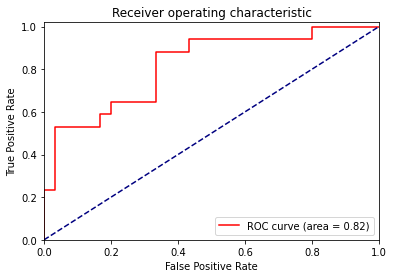

In [35]:
plt.plot(fpr,tpr, color = 'red', label='ROC curve (area = %0.2f)' % auc_score)
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.02])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc=4)
fig = plt.gcf()
fig.savefig(save_root + '/roc_curve.png', dpi = fig.dpi)
plt.show()

## Grad CAM

In [36]:
class GradCAM:
    def __init__(self, module, target_layer):
        self.module = module
        self.target_layer = target_layer
        self.target_output = None
        self.target_output_grad = None
        
        def forward_hook(_, __, output):
            self.target_output = output.clone()
        
        def backward_hook(_, __, grad_output):
            assert len(grad_output) == 1
            self.target_output_grad = grad_output[0].clone()
            
        self.target_layer.register_forward_hook(forward_hook)
        self.target_layer.register_backward_hook(backward_hook)
        
    def forward_pass(self, image, clinical):
        self.module.eval()
        self.module.zero_grad()
        return self.module(image, clinical)
    
    def get_grad_cam(self, image, clinical, target_class = None):
        assert len(image.size()) == 3
        
        image = image.unsqueeze(0)
        clinical = clinical.unsqueeze(0)
        
        out = self.forward_pass(image, clinical)

        onehot = np.zeros((1, out.size()[-1]), dtype=np.float32)
        
        target_class = int(target_class)
        onehot[0][target_class] = 1
        onehot = torch.from_numpy(onehot).requires_grad_(True).cuda()

        out.backward(onehot)
        
        grad = self.target_output_grad
        grad = F.adaptive_avg_pool2d(grad, 1)
        
        feature = self.target_output
        feature = feature * grad
        feature = torch.sum(feature, dim=1)
        feature = F.relu(feature)
        
        return feature.squeeze()

In [37]:
'''heatmap for activation map'''
def build_heatmap(heat_ratio, size=(240, 240)):
    if isinstance(size, int):
        size = (size, size)
    min_value = heat_ratio.min()
    max_value = heat_ratio.max()
    heat_ratio = (heat_ratio - min_value) / (max_value - min_value)
    
    heat_ratio = np.where(heat_ratio<=0.5, 0, heat_ratio)
    heat_ratio = (heat_ratio*255).astype(np.uint8)
    heat_ratio = cv2.resize(heat_ratio, size)
    heatmap = cv2.applyColorMap(heat_ratio, cv2.COLORMAP_JET)
    
    r = heatmap[:, :, 0].reshape(240, 240, 1)
    g = heatmap[:, :, 1].reshape(240, 240, 1)
    b = heatmap[:, :, 2].reshape(240, 240, 1)
    
    heatmap_re = np.append(b, g, axis = 2)
    heatmap_re = np.append(heatmap_re, r, axis = 2)
    
    
    return heatmap_re

In [38]:
'''apply heatmap to CT image'''
def apply_heatmap(image, heatmap):
    image = image.transpose(1, 2, 0)
    img_min = image.min()
    img_max = image.max()
    img_re = (image - img_min) / (img_max - img_min)
    
    image = (img_re * 255).astype(np.uint8)

    img_heatmap = (image * 0.7) + (heatmap * 0.3)
    img_heatmap = img_heatmap.astype(np.uint8)
    return img_heatmap, image

In [39]:
target_layer = my_model.model._conv_head

In [40]:
cam = GradCAM(my_model, target_layer)

In [44]:
gradcam_root = '/home/SMC_data_2101xx_EGFR_deeplearning/EGFR_deep_learning/3ch_img_minmax/result/test_ver2/img_clinical/gradcam'

In [45]:
test_heatmap_save = np.array([]).reshape(0, 240, 240, 3)
heatmap_ratio_save = np.array([]).reshape(0, 240, 240)

In [46]:
for i in range(test_img.shape[0]):
    test_img_torch = torch.from_numpy(test_img[i]).type(torch.FloatTensor).cuda()
    test_target_class = test_real[i]
    test_clinic_torch = torch.from_numpy(test_clinic[i]).type(torch.FloatTensor).cuda()
    
    test_raw_heatmap = cam.get_grad_cam(test_img_torch, test_clinic_torch, test_target_class).detach().cpu().numpy()
    
    
    test_heatmap = build_heatmap(test_raw_heatmap)
    
    test_img_heatmap, test_image = apply_heatmap(test_img[i], test_heatmap)
    
    test_heatmap_save = np.append(test_heatmap_save, test_img_heatmap.reshape(1, 240, 240, 3), axis = 0)

    
    if predicted_test_output[i] == test_target_class:
        answer = 'correct'
    else:
        answer = 'wrong'

    gradcam_im = Image.fromarray(test_img_heatmap) 
    gradcam_im.save(gradcam_root + '/test_gradcam/' +str(answer) + '_' + str(i)+ '_' + str(int(test_p_number[i])) + '.png')
    
    heatmap_im = Image.fromarray(test_heatmap) 
    heatmap_im.save(gradcam_root + '/heatmap/ ' +str(answer) + '_' + str(i)+ '_' + str(int(test_p_number[i])) + '.png')

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in true_divide
  import sys


In [ ]:
test_img_root = '/home/SMC_data_2101xx_EGFR_deeplearning/EGFR_deep_learning/external_validationset/external_test/png'

In [ ]:
gray_scale_root = '/home/SMC_data_2101xx_EGFR_deeplearning/EGFR_deep_learning/3ch_img_minmax/result/clinical_0.85/external_validationset/external_test/test_img_gray'

In [ ]:
rgb_list = os.listdir(test_img_root)
rgb_list_re = [i for i in rgb_list if 'png' in i]

In [ ]:
for rgb_imgs in rgb_list_re:
    rgb_root = os.path.join(test_img_root, rgb_imgs)
    rgb_im = Image.open(rgb_root).convert("L")
    rgb_im = rgb_im.resize((240, 240))
    gray_save = os.path.join(gray_scale_root, rgb_imgs)
    rgb_im.save(gray_save)

In [ ]:
roi_root = '/home/SMC_data_2101xx_EGFR_deeplearning/EGFR_deep_learning/3ch_img_minmax/result/final/gradcam/test_img_roi'

In [ ]:
ct_roi_root = '/home/SMC_data_2101xx_EGFR_deeplearning/EGFR_deep_learning/3ch_img_minmax/result/final/gradcam/test_img_CT_with_roi'

In [ ]:
img_name = rgb_list_re

In [ ]:
for i in range(len(img_name)):
    ct = os.path.join(test_img_root, img_name[i])
    roi = os.path.join(roi_root, img_name[i])
    
    ct_img = Image.open(ct)
    roi_img = Image.open(roi)
    
    ct_np = np.asarray(ct_img)
    roi_np = np.asarray(roi_img)
    
    roi_r = roi_np[:, :, 1].reshape(64, 64, 1)
    black = np.zeros((64, 64, 1))
    
    roi_re = np.append(roi_r, black, axis = 2)
    roi_re = np.append(roi_re, black, axis = 2)
    
    ct_with_roi = (ct_np*0.8) + (roi_re*0.2)
    
    im = Image.fromarray(np.uint8(ct_with_roi))
    im = im.resize((240, 240))
    im.save(ct_roi_root + '/' + img_name[i])